In [3]:
!pip install pyspark

In [4]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("PakistanFloods").getOrCreate()

In [6]:
# Adjust the path if your folder/file is different
csv_path = "/content/drive/MyDrive/Colab Notebooks/Pakistan_Floods/ndma_data_floods.csv"

df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Preview the first 5 rows
df.show(5)

# Check the schema
df.printSchema()


+-----------+------------+---+---+---+-------------+---+---+---+-----------------+---------------+--------------------+-----------------+-------------------+
|     Region|Total deaths|M_D|F_D|C_D|total_injured|M_I|F_I|C_I|Roads_damaged(km)|Bridges damaged|Total_houses_damaged|livestock_damaged|Affected population|
+-----------+------------+---+---+---+-------------+---+---+---+-----------------+---------------+--------------------+-----------------+-------------------+
|       AJ&K|          48| 31| 17|  0|           24| 15|  9|  0|                0|              0|                 548|              792|              53700|
|Balochistan|         299|136| 73| 90|          181| 92| 40| 49|             1850|             22|               65997|           500000|            9182616|
|         GB|          22|  5| 11|  6|            6|  3|  0|  3|               16|             65|                1211|                0|              51500|
|        ICT|           1|  1|  0|  0|            0|

In [7]:
df = df.withColumnRenamed("Region", "region") \
       .withColumnRenamed("Total deaths", "total_deaths") \
       .withColumnRenamed("total_injured", "total_injured") \
       .withColumnRenamed("Roads_damaged(km)", "roads_damaged_km") \
       .withColumnRenamed("Bridges damaged", "bridges_damaged") \
       .withColumnRenamed("Total_houses_damaged", "total_houses_damaged") \
       .withColumnRenamed("livestock_damaged", "livestock_damaged") \
       .withColumnRenamed("Affected population", "affected_population")


In [8]:
df = df.na.fill({
    "total_deaths": 0,
    "total_injured": 0,
    "roads_damaged_km": 0,
    "bridges_damaged": 0,
    "total_houses_damaged": 0,
    "livestock_damaged": 0,
    "affected_population": 0
})


In [9]:
from pyspark.sql.functions import col, sum

# Total affected population per region
df.groupBy("region").sum("affected_population").show()

# Total houses damaged per region
df.groupBy("region").sum("total_houses_damaged").show()



+-----------+------------------------+
|     region|sum(affected_population)|
+-----------+------------------------+
|      Sindh|                14563770|
|       AJ&K|                   53700|
|     Punjab|                 4844253|
|         GB|                   51500|
|         KP|                 4350490|
|        ICT|                       0|
|Balochistan|                 9182616|
+-----------+------------------------+

+-----------+-------------------------+
|     region|sum(total_houses_damaged)|
+-----------+-------------------------+
|      Sindh|                  1717788|
|       AJ&K|                      548|
|     Punjab|                    66971|
|         GB|                     1211|
|         KP|                    91463|
|        ICT|                        0|
|Balochistan|                    65997|
+-----------+-------------------------+



In [12]:
import os

# Create folder if it doesn't exist
if not os.path.exists("charts"):
    os.makedirs("charts")


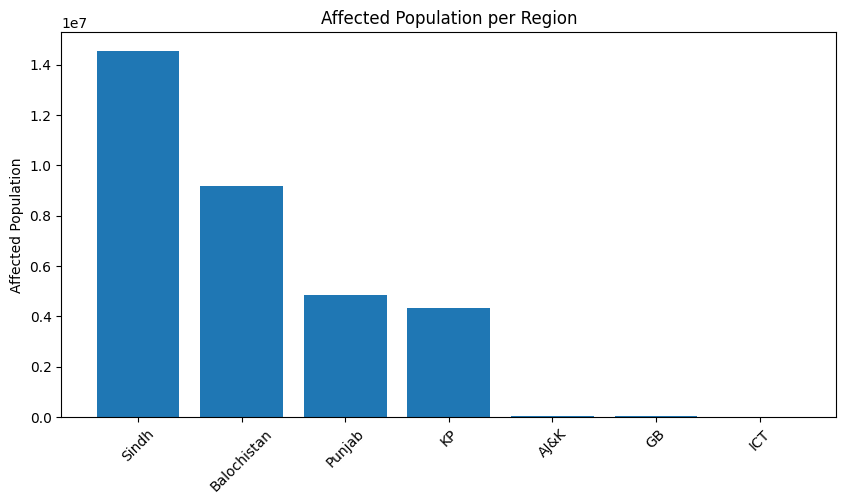

In [13]:
# Convert aggregation to Pandas for plotting
pdf = df.groupBy("region").sum("affected_population").orderBy(col("sum(affected_population)").desc()).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(pdf["region"], pdf["sum(affected_population)"])
plt.xticks(rotation=45)
plt.ylabel("Affected Population")
plt.title("Affected Population per Region")
plt.savefig("charts/total_affected_population.png")
plt.show()


In [17]:
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank, col

# Aggregate total houses damaged per region
df_region = df.groupBy("region") \
              .sum("total_houses_damaged") \
              .withColumnRenamed("sum(total_houses_damaged)", "total_houses_damaged")

# Define window spec for ranking
windowSpec = Window.orderBy(col("total_houses_damaged").desc())

# Apply dense_rank
df_ranked = df_region.withColumn("houses_damaged_rank", dense_rank().over(windowSpec))


In [18]:
top5 = df_ranked.filter(col("houses_damaged_rank") <= 5) \
                .select("region", "total_houses_damaged") \
                .toPandas()

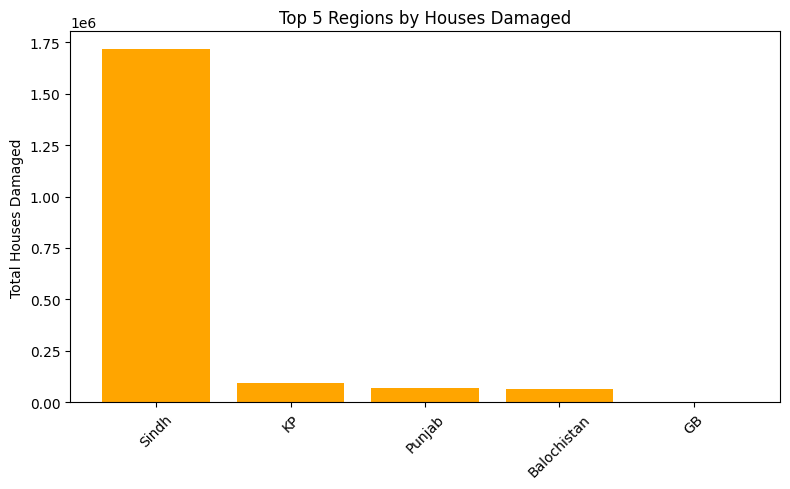

In [19]:
import matplotlib.pyplot as plt
import os

# Create charts folder if it doesn't exist
if not os.path.exists("charts"):
    os.makedirs("charts")

plt.figure(figsize=(8,5))
plt.bar(top5["region"], top5["total_houses_damaged"], color='orange')
plt.xticks(rotation=45)
plt.ylabel("Total Houses Damaged")
plt.title("Top 5 Regions by Houses Damaged")
plt.tight_layout()
plt.savefig("charts/top5_houses_damaged.png")
plt.show()


In [ ]:
df.createOrReplaceTempView("floods")
spark.sql("""
    SELECT region, SUM(affected_population) as total_affected
    FROM floods
    GROUP BY region
    ORDER BY total_affected DESC
""").show()
